## Definição do *dataset*

O *dataset utilizado será o "TOWARDS LIMB POSITION INVARIANT MYOELECTRIC PATTERN RECOGNITION USING TIME-DEPENDENT SPECTRAL FEATURES" [1]. Maiores informações podem ser vistas no site: https://www.rami-khushaba.com/electromyogram-emg-repository.html

Neste *dataset* existem 5 posições e 8 movimentos. Algumas questões de projetos foram levadas em consideração:
1. A primeira posição (P1) possui 40.000 *samples* e todas as outras possuem 20.000 *samples*. Desta forma, a posição 1 foi **excluída** do experimento de teste;
2. Cada posição possui 5 tentativas. Desta forma, serão utilizadas todas as tentativas do mesmo movimento como uma soma total de *samples* (todas as tentativas serão concatenadas);
3. Como este experimento resultará em 4 posições e 8 movimentos, será considerado primeiramente um experimento com 32 classes (4 * 8) e um segundo experimento com 8 classes (somando/dispresando as posições do braço).

[1] R. N. Khushaba, Maen Takruri, Jaime Valls Miro, and Sarath Kodagoda, "Towards limb position invariant myoelectric pattern recognition using time-dependent spectral features", Neural Networks, vol. 55, pp. 42-58, 2014. https://doi.org/10.1016/j.neunet.2014.03.010

### Separação das classes

In [2]:
from glob import glob

# exclusão dos arquivos com "Pos1" no nome
arquivos = glob("datasets/EMG_data/Pos[2-5]*.txt")
# índices para as 32 classes considerando as posições de 2 à 5
cl32 = {
    "Pos2_HandOpen": list(), "Pos3_HandOpen": list(), "Pos4_HandOpen": list(), "Pos5_HandOpen": list(),
    "Pos2_HandRest": list(), "Pos3_HandRest": list(), "Pos4_HandRest": list(), "Pos5_HandRest": list(),
    "Pos2_ObjectGrip": list(), "Pos3_ObjectGrip": list(), "Pos4_ObjectGrip": list(), "Pos5_ObjectGrip": list(),
    "Pos2_PichGrip": list(), "Pos3_PichGrip": list(), "Pos4_PichGrip": list(), "Pos5_PichGrip": list(),
    "Pos2_WristExten": list(), "Pos3_WristExten": list(), "Pos4_WristExten": list(), "Pos5_WristExten": list(),
    "Pos2_WristFlex": list(), "Pos3_WristFlex": list(), "Pos4_WristFlex": list(), "Pos5_WristFlex": list(),
    "Pos2_WristPron": list(), "Pos3_WristPron": list(), "Pos4_WristPron": list(), "Pos5_WristPron": list(),
    "Pos2_WristSupi": list(), "Pos3_WristSupi": list(), "Pos4_WristSupi": list(), "Pos5_WristSupi": list(),
}
# índices para as 8 classes desconsiderando as posições de 2 à 5
cl08 = {
    "HandOpen": list(),
    "HandRest": list(),
    "ObjectGrip": list(),
    "PichGrip": list(),
    "WristExten": list(),
    "WristFlex": list(),
    "WristPron": list(),
    "WristSupi": list(),
}

## Carregamento do *dataset*

Neste trecho de código, todos as amostras serão dividas entre os conjuntos de calsses específicas

In [3]:
import re

for arquivo in arquivos:
    trial_file = open(arquivo)
    nome = trial_file.name.split('/')[-1].split('.')[0]
    trial = list()
    for linha in trial_file.readlines():
        # foi necessário substituir os números "int" por "float"
        linha = re.sub(r"(?<=\ )(\d)(?=\ )", r"\1.0", linha)
        # casamento da linha com 7 pontos (1 para cada eletrodo)
        sample = [float(s) for s in re.findall(r"\-?\d\.\d+", linha)]
        trial.append(sample)
    cl08["{}".format(nome[5:-3])].append(trial)
    cl32["Pos{}{}".format(nome[3], nome[4:-3])].append(trial)

Agora será realizado a divisão dos dados e suas respectivas classes em sequência, formando dados em `numpy.array` para X1 (dados EMG das 8 classes), y1 (*labels* das 8 classes), X2 (dados EMG das 32 classes), y2 (*labels* das 32 classes)

In [4]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

X1 = np.array(list(cl08.values()))
X2 = np.array(list(cl32.values()))
# transformando labels categóricos em numéricos
le = LabelEncoder()
y1 = np.array(le.fit_transform(list(cl08.keys())))
y2 = np.array(le.fit_transform(list(cl32.keys())))
# shape: [8 classes, 24 trials, 20000 samples, 7 eletrodos]
print(X1.shape)
# shape: [32 classes, 6 trials, 20000 samples, 7 eletrodos]
print(X2.shape)
print(y1)
print(y2)

X1 = X1.swapaxes(2, 3)
X2 = X2.swapaxes(2, 3)
print(X1.shape)
print(X2.shape)

(8, 24, 20000, 7)
(32, 6, 20000, 7)
[0 1 2 3 4 5 6 7]
[ 0  8 16 24  1  9 17 25  2 10 18 26  3 11 19 27  4 12 20 28  5 13 21 29
  6 14 22 30  7 15 23 31]
(8, 24, 7, 20000)
(32, 6, 7, 20000)


## Segmentação dos dados ###

Com amostras divididas em 10, 20, 40, 50, 80 e 90 partes e com tamanhos da sobreposição de ~10%, ~20%, ~30%, ~40%, ~50%, ~70%, ~90%:

### Informações para segmentação nos dados no domínio do tempo:

##### ~10% de sobreposição:
* 10 partes = (salto = 1848, segmento = 2048);
* 20 partes = (salto = 992,  segmento = 1128);
* 40 partes = (salto = 496,   segmento = 562);
* 50 partes = (salto = 398,   segmento = 436);
* 80 partes = (salto = 248,   segmento = 272);
* 90 partes = (salto = 220,   segmento = 244).

##### ~20% de sobreposição:
* 10 partes = (salto = 1920, segmento = 2400);
* 20 partes = (salto = 986,  segmento = 1240);
* 40 partes = (salto = 488,  segmento =  608);
* 50 partes = (salto = 396,  segmento =  492);
* 80 partes = (salto = 248,  segmento =  312); 
* 90 partes = (salto = 276,  segmento =  220).

##### ~30% de sobreposição:
* 10 partes = (salto = 1880, segmento = 2648);
* 20 partes = (salto = 966,  segmento = 1380);
* 40 partes = (salto = 492,  segmento =  702);
* 50 partes = (salto = 392,  segmento =  560);
* 80 partes = (salto = 248,  segmento =  352); 
* 90 partes = (salto = 220,  segmento =  312);

##### ~40% de sobreposição:
* 10 partes = (salto = 1766,segmento = 2944);
* 20 partes = (salto = 924, segmento = 1540);
* 40 partes = (salto = 484, segmento = 808 );
* 50 partes = (salto = 394, segmento = 656 );
* 80 partes = (salto = 246, segmento = 410 ); 
* 90 partes = (salto = 220, segmento = 366 );

##### ~50% de sobreposição:
* 10 partes = (salto = 1792, segmento = 3584);
* 20 partes = (salto = 928,  segmento = 1856);
* 40 partes = (salto = 480,  segmento = 960 );
* 50 partes = (salto = 392,  segmento = 784 );
* 80 partes = (salto = 246,  segmento = 492 ); 
* 90 partes = (salto = 218,  segmento = 436 );

##### ~70% de sobreposição:
* 10 partes = (salto = 1536, segmento = 5120);
* 20 partes = (salto = 864,  segmento = 2880);
* 40 partes = (salto = 470,  segmento = 1568);
* 50 partes = (salto = 380,  segmento = 1272);
* 80 partes = (salto = 242,  segmento = 808 ); 
* 90 partes = (salto = 216,  segmento = 720 );

##### ~90% de sobreposição:
* 10 partes = (salto = 1024, segmento = 10240);
* 20 partes = (salto = 686,  segmento = 6854 );
* 40 partes = (salto = 404,  segmento = 4032 );
* 50 partes = (salto = 336,  segmento = 3360 );
* 80 partes = (salto = 224,  segmento = 2240 ); 
* 90 partes = (salto = 202,  segmento = 2016 ).

In [5]:
print(X1.shape)
# definição do salto e do tamanho do segmento (segmento - salto = sobreposição)
salto = 864
segmento = 2880
n_win = int((X1.shape[-1] - segmento) / salto) + 1
ids = np.arange(n_win) * salto
x_8 = np.array([X1[:,:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 3, 0, 4)
print(x_8.shape)

print(X2.shape)
# definição do salto e do tamanho do segmento (segmento - salto = sobreposição)
n_win = int((X2.shape[-1] - segmento) / salto) + 1
ids = np.arange(n_win) * salto
x_32 = np.array([X2[:,:,:,k:(k + segmento)] for k in ids]).transpose(1, 2, 3, 0, 4)
print(x_32.shape)

(8, 24, 7, 20000)
(8, 24, 7, 20, 2880)
(32, 6, 7, 20000)
(32, 6, 7, 20, 2880)


### Caracteristicas no domínio do tempo:

* `Variance of EMG (VAR)`: 
    > $\frac{1}{N-1}\sum_{i=1}^{N}x_i^2$
* `Root Mean Square (RMS)`:
    > $\sqrt{\frac{1}{N-1}\sum_{i=1}^{N}|x_i|^2}$
* `Mean Absolute Value (MAV)`:
    > $\frac{1}{N}\sum_{i=1}^{N}|x_i|$
* `Zero Crossing (ZC)`:
    > $\sum_{i=1}^{N}sgn(-x_i x_{i+1})$
  onde sgn(X) = 1 se X > 0 | 0 caso contrário
* `Waveform length (WL)`:
    > $\sum_{i=1}^{N-1}|x_i-x_{i+1}|$
* `Simple Square Integral (SSI)`:
    > $\sum_{i=1}^{N}x_i^2$

In [ ]:
#Features 
feats_8 = list()
feats_32 = list()
label_8 = list()
label_32 = list()

# VAR
var_8  = np.sum(x_8 ** 2, axis=-1) / (np.prod(x_8.shape[:-1]) - 1)
var_32 = np.sum(x_32 ** 2, axis=-1) / (np.prod(x_32.shape[:-1]) - 1)
feats_8.append(var_8)
feats_32.append(var_32)
label_8.append("VAR_8")
label_32.append("VAR_32")

# RMS
rms_8  = np.sqrt(np.sum(np.abs(x_8) ** 2, axis=-1) / (np.prod(x_8.shape[:-1]) - 1))
rms_32 = np.sqrt(np.sum(np.abs(x_32) ** 2, axis=-1) / (np.prod(x_32.shape[:-1]) - 1))
feats_8.append(rms_8)
feats_32.append(rms_32)
label_8.append("RMS_8")
label_32.append("RMS_32")

# MAV
mav_8  = np.sum(np.abs(x_8), axis=-1) / (np.prod(x_8.shape[:-1]))
mav_32 = np.sum(np.abs(x_32), axis=-1) / (np.prod(x_32.shape[:-1]))
feats_8.append(mav_8)
feats_32.append(mav_32)
label_8.append("MAV_8")
label_32.append("MAV_32")

# ZC
def zc(x):
    for ind, value in np.ndenumerate(x):
        i, j, k, l, m = ind
        if (m+1 < x.shape[-1]): x[ind] = (1 if (((value*(-1))*x[i, j, k, l, m+1]) > 0) else 0)
        else:
            x[ind] = 0
    return x

zc_8 = zc(x_8)                    #Descomentar para executar ZC na primeira vez
zc_8 = np.sum(zc_8, axis=-1)      #Descomentar para executar ZC (demorando um pouco..)
#print(zc_8.shape)
zc_32 = zc(x_32)                  #Descomentar para executar ZC
zc_32 = np.sum(zc_32, axis=-1)    #Descomentar para executar ZC
feats_8.append(zc_8)
feats_32.append(zc_32)
label_8.append("ZC_8")
label_32.append("ZC_32")

#WL
wl_8 = np.sum(np.abs(np.diff(x_8, axis=-1)), axis=-1)
wl_32 = np.sum(np.abs(np.diff(x_32, axis=-1)), axis=-1)
feats_8.append(wl_8)
feats_32.append(wl_32)
label_8.append("WL_8")
label_32.append("WL_32")

#SSI
ssi_8 = np.sum(x_8 ** 2, axis=-1)
ssi_32 = np.sum(x_32 ** 2, axis=-1)
feats_8.append(ssi_8)
feats_32.append(ssi_32)
label_8.append("SSI_8")
label_32.append("SSI_32")

print(np.shape(feats_8))
print(np.shape(feats_32))

##### Transformação para domínio da frequencia

##### ~10% de sobreposição:
* 10 partes = (nperseg = 2560, noverlap = 256);
* 20 partes = (nperseg = 1216, noverlap = 128);
* 40 partes = (nperseg = 586,   noverlap = 60);
* 50 partes = (nperseg = 464,   noverlap = 48);
* 80 partes = (nperseg = 282,   noverlap = 28);
* 90 partes = (nperseg = 250,   noverlap = 24).

##### ~20% de sobreposição:
* 10 partes = (nperseg = 2816, noverlap = 564);
* 20 partes = (nperseg = 1344, noverlap = 268);
* 40 partes = (nperseg = 656,  noverlap = 132);
* 50 partes = (nperseg = 520,  noverlap = 104);
* 80 partes = (nperseg = 318,   noverlap = 64);
* 90 partes = (nperseg = 282,   noverlap = 56).

##### ~30% de sobreposição:
* 10 partes = (nperseg = 3200, noverlap = 960);
* 20 partes = (nperseg = 1536, noverlap = 460);
* 40 partes = (nperseg = 736,  noverlap = 220);
* 50 partes = (nperseg = 592,  noverlap = 178);
* 80 partes = (nperseg = 362,  noverlap = 108);
* 90 partes = (nperseg = 324,   noverlap = 98).

##### ~40% de sobreposição:
* 10 partes = (nperseg = 3712, noverlap = 1484);
* 20 partes = (nperseg = 1792,  noverlap = 716);
* 40 partes = (nperseg = 864,   noverlap = 236);
* 50 partes = (nperseg = 688,   noverlap = 276);
* 80 partes = (nperseg = 424,   noverlap = 170);
* 90 partes = (nperseg = 376,   noverlap = 150).

##### ~50% de sobreposição:
* 10 partes = (nperseg = 4480, noverlap = 2240);
* 20 partes = (nperseg = 2176, noverlap = 1088);
* 40 partes = (nperseg = 1048,  noverlap = 524);
* 50 partes = (nperseg = 824,   noverlap = 412);
* 80 partes = (nperseg = 512,   noverlap = 256);
* 90 partes = (nperseg = 452,   noverlap = 226).

##### ~70% de sobreposição:
* 10 partes = (nperseg = 7680, noverlap = 5376);
* 20 partes = (nperseg = 3584, noverlap = 2508);
* 40 partes = (nperseg = 1728, noverlap = 1210);
* 50 partes = (nperseg = 1376,  noverlap = 964);
* 80 partes = (nperseg = 848,   noverlap = 594);
* 90 partes = (nperseg = 752,   noverlap = 526).

##### ~90% de sobreposição:
* 10 partes = (nperseg = , noverlap = );
* 20 partes = (nperseg = 10752, noverlap = 9676);
* 40 partes = (nperseg = 5184,  noverlap = 4666);
* 50 partes = (nperseg = 4096,  noverlap = 3696);
* 80 partes = (nperseg = 2560,  noverlap = 2304);
* 90 partes = (nperseg = 2264,  noverlap = 2038).

In [7]:
from scipy.signal import stft

nperseg = 2176
noverlap = 1088

print(X1.shape)
_, _, w = stft(X1, fs=4000, nperseg=nperseg, noverlap=noverlap)
w = np.swapaxes(w, 3, 4)
print(w.shape)

print(X2.shape)
_, _, z = stft(X2, fs=4000, nperseg=nperseg, noverlap=noverlap)
z = np.swapaxes(z, 3, 4)
print(z.shape)

(8, 24, 7, 20000)
(8, 24, 7, 20, 1089)
(32, 6, 7, 20000)
(32, 6, 7, 20, 1089)


### Características no domínio da frequencia

* `Frequency Median (FMD)`:
    > $\frac{1}{2}\sum_{i=1}^{M}PSD$
* `Modified Median Frequency (MMDF)`:
    > $\frac{1}{2}\sum_{i=1}^{M}A_j$
* `Mean Power (MP)`:
    > $\frac{1}{M}\sum_{i=1}^{M}P_i$
* `Peak Frequency (PKF)`:
    > $max(P_i), i=1,...,M$

In [8]:
# definição da função PSD para o sinal no domínio da frequência
feats_8 = list()
label_8 = list()
feats_32 = list()
label_32 = list()

def PSD(x):
    return np.sqrt(np.abs(x))

# FMD
fmd_8 = np.sum(PSD(w), axis=-1) / 2
fmd_32 = np.sum(PSD(z), axis=-1) / 2
feats_8.append(fmd_8)
label_8.append("FMD_8")
feats_32.append(fmd_32)
label_32.append("FMD_32")
#print(fmd_8.shape)
#print(fmd_32.shape)

# MMDF
mmdf_8 = np.sum(np.abs(w), axis=-1) / 2
mmdf_32 = np.sum(np.abs(z), axis=-1) / 2
feats_8.append(mmdf_8)
label_8.append("MMDF_8")
feats_32.append(mmdf_32)
label_32.append("MMDF_32")
#print(mmdf_8.shape)
#print(mmdf_32.shape)

#MP
mp_8 = np.real(np.sum(w, axis=-1) / (np.prod(w.shape[:-1]))) 
mp_32 = np.real(np.sum(z, axis=-1) / (np.prod(z.shape[:-1])))
feats_8.append(mp_8)
label_8.append("MP_8")
feats_32.append(mp_32)
label_32.append("MP_32")
#print(mp_8.shape)
#print(mp_32.shape)

#PKF
pkf_8 = np.real(np.max(w, axis=-1))
pkf_32 = np.real(np.max(z, axis=-1))
feats_8.append(pkf_8)
label_8.append("PKF_8")
feats_32.append(pkf_32)
label_32.append("PKF_32")
#print(pkf_8.shape)
#print(pkf_32.shape)
print(np.shape(feats_8))
print(np.shape(feats_32))

print(label_8)
print(label_32)

(4, 8, 24, 7, 20)
(4, 32, 6, 7, 20)
['FMD_8', 'MMDF_8', 'MP_8', 'PKF_8']
['FMD_32', 'MMDF_32', 'MP_32', 'PKF_32']


### Vetor de características

In [9]:
from itertools import combinations

feats_8 = np.array(feats_8)
feats_32 = np.array(feats_32)
combination_8 = list()
combination_32 = list()
labels_8 = list()
labels_32 = list()

for k in range(1, feats_8.shape[0]+1):
    combination_8.append([item for item in combinations(feats_8, k)])
    combination_32.append([item for item in combinations(feats_32, k)])
    labels_8.append([item for item in combinations(label_8, k)])
    labels_32.append([item for item in combinations(label_32, k)])
#print(np.shape(combination[3]))
#print(labels[3])

###### Conjuntos de características:
O código acima está gerando todas as possíveis combinações de características possível com o vetor de características. Para prosseguir é necessário definir 'i' e 'j' para informar o conjunto de caracteristicas desejado:

* i = 0 trás os conjuntos com apenas 1 característica (10 disponíveis, selecionados com j de 0-9);
* i = 1 trás os conjuntos com 2 características (45 disponíveis, selecionados com j = 0-44);
* i = 2 trás os conjuntos com 3 características (120 disponíveis, selecionados com j = 0-119);
* i = 3 trás os conjuntos com 4 características (210 disponíveis, selecionados com j = 0-209);
* i = 4 trás os conjuntos com 5 características (252 disponíveis, selecionados com j = 0-251);
* i = 5 trás os conjuntos com 6 características (210 disponíveis, selecionados com j = 0-209);
* i = 6 trás os conjuntos com 7 características (120 disponíveis, selecionados com j = 0-119);
* i = 7 trás os conjuntos com 8 características (45 disponíveis, selecionados com j = 0-44);
* i = 8 trás os conjuntos com 9 características (10 disponíveis, selecionados com j = 0-9);
* i = 9 trás o conjunto com as 10 características (1 disponível, selecionado com j = 0).

###### 1023 possibilidades  :-0

In [10]:
i = 3
j = 0

print(labels_8[i][j], np.shape(combination_8[i]))
features = list()
for feature in (combination_8[i][j]):
    feature = np.array(feature)
    feature = feature.transpose(0, 1, 3, 2)
    feature = feature.reshape(feats_8.shape[1] * feats_8.shape[2] * feats_8.shape[-1], 7)
    print('Feature: {}'.format(feature), feature.shape)
    features.append(feature)
    
print(np.shape(features))

X_8 = np.concatenate(features, axis=-1)
X_8.shape

print(labels_32[i][j])
features = list()
for feature in (combination_32[i][j]):
    feature = np.array(feature)
    feature = feature.transpose(0, 1, 3, 2)
    feature = feature.reshape(feats_32.shape[1] * feats_32.shape[2] * feats_32.shape[-1], 7)
    print('Feature: {}'.format(feature), feature.shape)
    features.append(feature)
    
print(np.shape(features))

X_32 = np.concatenate(features, axis=-1)
X_32.shape

('FMD_8', 'MMDF_8', 'MP_8', 'PKF_8') (1, 4, 8, 24, 7, 20)
Feature: [[ 5.79354423  7.79524045 20.81699152 ... 18.38869561  7.49460718
   6.92730095]
 [ 6.30798852  8.59792276 20.62691109 ... 16.98404492  8.7240527
   6.31516051]
 [ 6.3338135   8.27121854 19.79853598 ... 16.7496129   8.49562869
   6.24838431]
 ...
 [ 6.34962265  8.54947383 21.01556453 ... 14.10054149  8.0268767
   6.38900096]
 [ 6.22931536  8.88733958 24.67749821 ... 13.7038448   8.91737957
   6.84329369]
 [ 2.38297683  4.03077872 10.93405574 ...  5.05898866  3.97239454
   2.80200909]] (3840, 7)
Feature: [[0.1389132  0.28100776 1.85822507 ... 1.44325578 0.30649762 0.15734636]
 [0.16813663 0.3939584  2.31441547 ... 1.81034174 0.41690698 0.18248245]
 [0.17061051 0.36465701 2.12279659 ... 1.73213627 0.39975537 0.17779691]
 ...
 [0.17096385 0.40497689 2.52525646 ... 1.13240315 0.30468228 0.17923188]
 [0.16752535 0.38528871 2.48368959 ... 1.06957795 0.29695434 0.19514058]
 [0.02462918 0.06160212 0.31925399 ... 0.15089648 0.04

(3840, 28)

Vetor de labels

In [11]:
y = np.array([[str(i)] * int(X_8.shape[0] / 8) for i in range(8)])
y = y.reshape(y.shape[0] * y.shape[1])
print(y.shape)

y2 = np.array([[str(i)] * int(X_32.shape[0] / 32) for i in range(32)])
y2 = y2.reshape(y2.shape[0] * y2.shape[1])
print(y2.shape)

(3840,)
(3840,)


## Classificadores

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# treino e teste em 70 e 30% respectivamente
X_train8, X_test8, y_train8, y_test8 = train_test_split(X_8, y, test_size=0.3, shuffle=True)
X_train32, X_test32, y_train32, y_test32 = train_test_split(X_32, y2, test_size=0.3, shuffle=True)

# SVM (SVC)
svm8 = SVC(gamma='auto')
svm8.fit(X_train8, y_train8)
res_svm8 = svm8.predict(X_test8)

svm32 = SVC(gamma='auto')
svm32.fit(X_train32, y_train32)
res_svm32 = svm32.predict(X_test32)

#KNN
knn8 = KNeighborsClassifier(n_neighbors=5)
knn8.fit(X_train8, y_train8)
res_knn8 = knn8.predict(X_test8)

knn32 = KNeighborsClassifier(n_neighbors=5)
knn32.fit(X_train32, y_train32)
res_knn32 = knn32.predict(X_test32)

#LDA
lda8 = LDA()
lda8.fit(X_train8, y_train8)
res_lda8 = lda8.predict(X_test8)

lda32 = LDA()
lda32.fit(X_train32, y_train32)
res_lda32 = lda32.predict(X_test32)

In [82]:
from sklearn import metrics

print('Acurácia SVM - 8 classes: {:.2f}%'.format((metrics.accuracy_score(y_test8, res_svm8)) * 100))
print('Acurácia KNN - 8 classes: {:.2f}%'.format((metrics.accuracy_score(y_test8, res_knn8)) * 100))
print('Acurácia LDA - 8 classes: {:.2f}%'.format((metrics.accuracy_score(y_test8, res_lda8)) * 100))
print()
print('Acurácia SVM - 32 classes: {:.2f}%'.format((metrics.accuracy_score(y_test32, res_svm32)) * 100))
print('Acurácia KNN - 32 classes: {:.2f}%'.format((metrics.accuracy_score(y_test32, res_knn32)) * 100))
print('Acurácia LDA - 32 classes: {:.2f}%'.format((metrics.accuracy_score(y_test32, res_lda32)) * 100))

Acurácia SVM - 8 classes: 95.83%
Acurácia KNN - 8 classes: 96.53%
Acurácia LDA - 8 classes: 82.38%

Acurácia SVM - 32 classes: 86.81%
Acurácia KNN - 32 classes: 88.02%
Acurácia LDA - 32 classes: 87.50%


## RNN - 8 classes

In [112]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

#RNN

y_train8 = y_train8.astype((np.float))
y_test8 = y_test8.astype((np.float))
model = Sequential()
model.add(Dense(512, input_shape=(X_train8.shape[1],), activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
          
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
          
model.add(Dense(8, activation='softmax'))
          
opt = Adam(learning_rate=0.01, decay=0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history_8 = model.fit(X_train8, y_train8, epochs=50, batch_size=128, validation_data=(X_test8, y_test8))

Epoch 1/50
21/21 [==============================] - 0s 14ms/step - loss: 3.3330 - accuracy: 0.2028 - val_loss: 1.7155 - val_accuracy: 0.4375
Epoch 2/50
21/21 [==============================] - 0s 10ms/step - loss: 1.5627 - accuracy: 0.3400 - val_loss: 1.1813 - val_accuracy: 0.4957
Epoch 3/50
21/21 [==============================] - 0s 11ms/step - loss: 1.2331 - accuracy: 0.4624 - val_loss: 1.0020 - val_accuracy: 0.6701
Epoch 4/50
21/21 [==============================] - 0s 11ms/step - loss: 1.0440 - accuracy: 0.5569 - val_loss: 0.8181 - val_accuracy: 0.7266
Epoch 5/50
21/21 [==============================] - 0s 9ms/step - loss: 0.8747 - accuracy: 0.6347 - val_loss: 0.6068 - val_accuracy: 0.8064
Epoch 6/50
21/21 [==============================] - 0s 10ms/step - loss: 0.7864 - accuracy: 0.6864 - val_loss: 0.6536 - val_accuracy: 0.7517
Epoch 7/50
21/21 [==============================] - 0s 10ms/step - loss: 0.7183 - accuracy: 0.7169 - val_loss: 0.5261 - val_accuracy: 0.7925
Epoch 8/50
21/

## Função para plotar gráfico com curva de aprendizado

In [ ]:
import matplotlib.pyplot as plt


def plot_learningCurve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    


Rotina Simples

## RNN - 32 classes

In [110]:
#RNN

y_train32 = y_train32.astype((np.float))
y_test32 = y_test32.astype((np.float))
model = Sequential()
model.add(Dense(512, input_shape=(X_train32.shape[1],), activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
          
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
          
model.add(Dense(32, activation='softmax'))
          
opt = Adam(learning_rate=0.01, decay=0.00001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history_32 = model.fit(X_train32, y_train32, epochs=50, batch_size=128, validation_data=(X_test32, y_test32))

Epoch 1/100
21/21 [==============================] - 0s 14ms/step - loss: 4.0287 - accuracy: 0.0867 - val_loss: 2.6366 - val_accuracy: 0.2023
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 2.2961 - accuracy: 0.2545 - val_loss: 1.4637 - val_accuracy: 0.4948
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 1.5947 - accuracy: 0.4174 - val_loss: 1.1705 - val_accuracy: 0.5503
Epoch 4/100
21/21 [==============================] - 0s 10ms/step - loss: 1.3175 - accuracy: 0.5052 - val_loss: 0.9748 - val_accuracy: 0.6181
Epoch 5/100
21/21 [==============================] - 0s 11ms/step - loss: 1.1866 - accuracy: 0.5461 - val_loss: 0.9326 - val_accuracy: 0.6458
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 1.0999 - accuracy: 0.5978 - val_loss: 0.9297 - val_accuracy: 0.6267
Epoch 7/100
21/21 [==============================] - 0s 12ms/step - loss: 1.1254 - accuracy: 0.5737 - val_loss: 0.7990 - val_accuracy: 0.7179
Epoch 

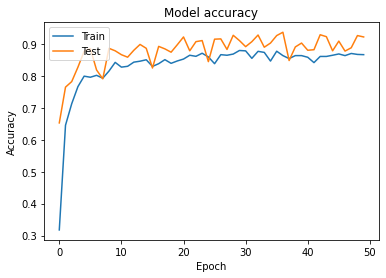

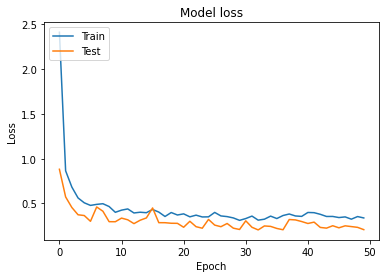

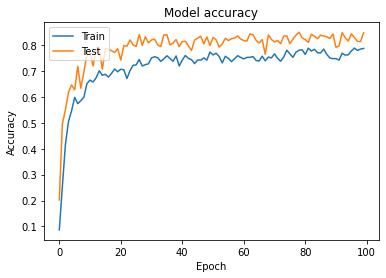

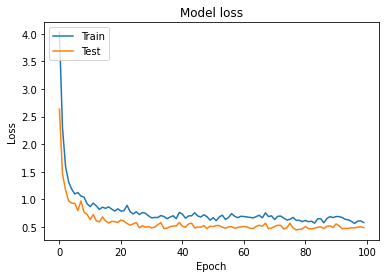

In [111]:
plot_learningCurve(history_8)
plot_learningCurve(history_32)